In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch.nn.functional as F
from torchvision.transforms import Compose
import random
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from pydub import AudioSegment, silence

In [2]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal,title='', sr=None, color='blue'):
    plt.figure(figsize=(7,2))
    plt.title(title)
    return librosa.display.waveshow(signal, sr=sr, color=color)

In [3]:
import noisereduce as nr

def signum(x):
    return 1 if x>0 else -1

def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    denoised_signal = nr.reduce_noise(signal, sr=sample_rate)
    denoised_signal_boosted = np.where((np.abs(denoised_signal)>.04) & (np.abs(denoised_signal)<.4), (0.4-denoised_signal) * 1.15, denoised_signal)
    # if show:
    #     disp_waveform(denoised_signal, 'signal waveform DENOISED', sr=sample_rate)
    #     disp_waveform(signal, 'signal waveform NOISED', sr=sample_rate)
    #     disp_waveform(denoised_signal_boosted, 'signal waveform DENOISED n BOOSTED', sr=sample_rate)
    # signal = denoised_signal
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    norm = np.linalg.norm(energy)
    energy = energy/norm
    # -- energy'
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float), sr=sample_rate)
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    timestamps = []
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            if len(keystroke) >= before + after:
                strokes.append(keystroke)
                timestamps.append(timestamp)
                if show and len(strokes) <= 3:
                    disp_waveform(keystroke, title=f'keystroke {len(strokes)}', sr=sample_rate)
                prev_end = timestamp+after
    return peaks, strokes, timestamps

In [4]:
def partition_audio(samples_arr : np.array):
    ret_samples = np.abs(samples_arr)
    return ret_samples

In [5]:
import numpy as np
from collections import deque

def find_key_presses(waveform, res, waveform_threshold, waveform_max, threshold_background, history_size, remove_low_power):
    # Clear previous results
    # res.clear()
    # waveform_threshold = np.zeros_like(waveform)
    # waveform_max = np.zeros_like(waveform)
    # 
    rb_begin = 0
    rb_average = 0.0
    rb_samples = np.zeros(history_size)

    k = history_size
    que = deque(maxlen=k)

    samples = np.abs(waveform)  # Taking absolute values like waveformAbs in C++
    n = len(samples)
    overall_loudness = 0
    len_ovr_loudness = 0
    for i in range(n):
        ii = i - k // 2
        if ii >= 0:
            rb_average *= len(rb_samples)
            rb_average -= rb_samples[rb_begin]
            acur = samples[i]
            rb_samples[rb_begin] = acur
            rb_average += acur
            rb_average /= len(rb_samples)
            rb_begin = (rb_begin + 1) % len(rb_samples)
        if i < k:
            # Handling initial filling of the deque
            while que and samples[i] >= samples[que[-1]]:
                que.pop()
            que.append(i)
        else:
            # Maintain the deque as a max-queue for the sliding window
            while que and que[0] <= i - k:
                que.popleft()

            # same code as if i<k
            while que and samples[i] >= samples[que[-1]]:
                que.pop()
            que.append(i)

            itest = i - k // 2
            if  k <= itest < n - k and que[0] == itest:
                acur = samples[itest]
                if acur > threshold_background * rb_average:
                    res.append({
                        'waveform': waveform[itest - k//6 : itest + (5*k)//6],
                        'index': itest
                    })
                    quiet_part = samples[itest + (3*k)//6 : itest + (5*k)//6]
                    len_ovr_loudness += len(quiet_part)
                    overall_loudness += np.sum(quiet_part)
            waveform_threshold[itest] = threshold_background * rb_average
            waveform_max[itest] = samples[que[0]]

    if remove_low_power:
        while True:
            old_n = len(res)

            avg_power = sum(samples[kp["position"]] for kp in res) / len(res)

            tmp_res = res[:]
            res.clear()

            for kp in tmp_res:
                if samples[kp["position"]] > 0.3 * avg_power:
                    res.append(kp)

            if len(res) == old_n:
                break
    
    avg_loudness = overall_loudness / len_ovr_loudness

    return {'waveform_threshold': waveform_threshold, 
            'waveform_max': waveform_max,
            'res': res,
            'avg_loudness': avg_loudness
            }

In [6]:
import array

def numpy_to_audiosegment(samples, sample_rate=44100, sample_width=2, channels=1):
    # Ensure the numpy array is in the correct dtype (int16 or int32 based on sample_width)
    if sample_width == 2:
        samples = np.int16(samples)
    elif sample_width == 4:
        samples = np.int32(samples)
    
    # Convert numpy array to byte data
    audio_data = array.array('h', samples)  # 'h' for 16-bit PCM audio
    byte_data = audio_data.tobytes()
    
    # Create AudioSegment
    audio_segment = AudioSegment(
        data=byte_data,
        sample_width=sample_width,  # 2 for 16-bit, 4 for 32-bit
        frame_rate=sample_rate,
        channels=channels
    )
    
    return audio_segment

In [7]:
import pyloudnorm as pyln

# constants
N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2400, 12000

# for num in range(10):
#     # MKA Datasets instance
#     samples, sr = librosa.load(f'../MKA datasets/All Dataset/Raw Data/{num}/{num}mac.wav', sr=44100)
#     pydub_samples = AudioSegment.from_file(f'../MKA datasets/All Dataset/Raw Data/{num}/{num}mac.wav', format="wav", frame_rate=44100)
#     disp_waveform(samples, sr=44100)
# 
#     samples2, sr = librosa.load(f'../Dataset-for-Binary/base-audio/audio_{num}.wav', sr=44100)
#     pydub_samples2 = AudioSegment.from_file(f'../Dataset-for-Binary/base-audio/audio_{num}.wav', format='wav', 
#                                            frame_rate=44100, sample_width=4)
# 
#     silences = silence.detect_silence(pydub_samples, silence_thresh=1.01*pydub_samples.dBFS, min_silence_len=10)
#     ovr_dbms = []
#     for start_ind, final_ind in silences:
#         ovr_dbms.append(pydub_samples[start_ind:final_ind].dBFS)
#     avg_dbfs = np.average(ovr_dbms)
# 
#     silences2 = silence.detect_silence(pydub_samples2, silence_thresh=1.01*pydub_samples2.dBFS, min_silence_len=10)
#     ovr_dbms2 = []
#     for start_ind, final_ind in silences2:
#         ovr_dbms2.append(pydub_samples2[start_ind:final_ind].dBFS)
#     avg_dbfs2 = np.average(ovr_dbms2)
# 
#     print(f'num={num:.1f}')
#     print("AUDIO MKA")
#     return_dic = find_key_presses(samples,[],{},{},np.abs(0.16*avg_dbfs), 14400, False)
#     print(f'\tbackground_prof: {(0.17*avg_dbfs):.3f} / Number of keys: {len(return_dic["res"])}')
# 
#     print("AUDIO ORIGINAL")
#     return_dic2 = find_key_presses(samples2,[],{},{},np.abs(0.16*avg_dbfs2), 14400, False)
#     print(f'\tbackground_prof: {(0.17*avg_dbfs2):.3f} / Number of keys: {len(return_dic2["res"])}')
#     print()

# print('MKA Dataset instance')
# print(f'dBFS: {pydub_samples.dBFS:.3f}')
# print('Silence moments')
# # print(np.array(timestamps)/44100*1000)
# 
# the number 1
key_length = 8820
for num in range(1, 5):
    samples, sr = librosa.load(f'../MKA datasets/All Dataset/Raw Data/{num}/{num}mac.wav', sr=44100)
    pydub_samples = AudioSegment.from_file(f'../MKA datasets/All Dataset/Raw Data/{num}/{num}mac.wav', format="wav", frame_rate=44100)
    
    samples2, sr = librosa.load(f'../Dataset-for-Binary/base-audio/audio_{num}.wav', sr=44100)
    pydub_samples2 = AudioSegment.from_file(f'../Dataset-for-Binary/base-audio/audio_{num}.wav', format='wav', 
                                           frame_rate=44100, sample_width=4)
    
    silences = silence.detect_silence(pydub_samples, silence_thresh=1.01*pydub_samples.dBFS, min_silence_len=50)
    ovr_dbms = []
    for start_ind, final_ind in silences:
        ovr_dbms.append(pydub_samples[start_ind:final_ind].dBFS)
    avg_dbfs = np.average(ovr_dbms)
    
    # the number 2
    silences2 = silence.detect_silence(pydub_samples2, silence_thresh=1.01*pydub_samples2.dBFS, min_silence_len=50)
    ovr_dbms2 = []
    for start_ind, final_ind in silences2:
        ovr_dbms2.append(pydub_samples2[start_ind:final_ind].dBFS)
    avg_dbfs2 = np.average(ovr_dbms2)
    
    threshold_vals = np.arange(0.3, 0.65, 0.01)
    print(f'KEY {num}')
    for i in threshold_vals:
        print(f'i={i:.3f}')
        print("AUDIO MKA")
        print(f'avg dBFS: {avg_dbfs:.3f}')
        return_dic = find_key_presses(samples,[],{},{},np.abs(i*avg_dbfs), key_length, False)
        print(f'\tbackground_prof: {abs(i*avg_dbfs):.3f} / Number of keys: {len(return_dic["res"])}')
        print("AUDIO ORIGINAL")
        print(f'avg dBFS: {avg_dbfs2:.3f}')
        return_dic2 = find_key_presses(samples2,[],{},{},np.abs(i*avg_dbfs2), key_length, False)
        print(f'\tbackground_prof: {abs(i*avg_dbfs2):.3f} / Number of keys: {len(return_dic2["res"])}')
        print()


KEY 1
i=0.300
AUDIO MKA
avg dBFS: -45.736
	background_prof: 13.721 / Number of keys: 34
AUDIO ORIGINAL
avg dBFS: -35.108
	background_prof: 10.532 / Number of keys: 2

i=0.310
AUDIO MKA
avg dBFS: -45.736
	background_prof: 14.178 / Number of keys: 34
AUDIO ORIGINAL
avg dBFS: -35.108
	background_prof: 10.883 / Number of keys: 2

i=0.320
AUDIO MKA
avg dBFS: -45.736
	background_prof: 14.635 / Number of keys: 33
AUDIO ORIGINAL
avg dBFS: -35.108
	background_prof: 11.235 / Number of keys: 2

i=0.330
AUDIO MKA
avg dBFS: -45.736


KeyboardInterrupt: 

In [8]:
from detecta import detect_peaks

def count_peaks(samples, key_length=14400):
    final_samples = pyln.normalize.peak(samples, -1)
    indexes = detect_peaks(final_samples[key_length: -key_length], show=True, mpd=key_length, mph=0.04)
    return len(indexes)

def isolator_new(file_path, sr, key_length=14400, k=0.15):
    pydub_samples = AudioSegment.from_file(file_path, format="wav", frame_rate=sr)
    silences = silence.detect_silence(pydub_samples, silence_thresh=1.01*pydub_samples.dBFS, min_silence_len=50)
    ovr_dbms = []
    for start_ind, final_ind in silences:
        ovr_dbms.append(pydub_samples[start_ind:final_ind].dBFS)
    avg_dbfs = np.average(ovr_dbms)
    return_dic = find_key_presses(samples,[],{},{},np.abs(k*avg_dbfs), key_length, False)
    return return_dic

In [9]:
def create_dataset(keys, initial_k, key_length=8820):
    data_dict = {'Key':[], 'File':[]}
    for i, key in enumerate(keys):
        curr_key = key
        if key.isalpha and not key.isalnum(): # if is a string
            curr_key = key.lower()
        file_path = f'../MKA datasets/All Dataset/Raw Data/{curr_key}/{curr_key}mac.wav'
        samples, sr = librosa.load(file_path, sr=44100)
    
        # peaks_count
        peaks_count = count_peaks(samples, key_length)
        
        # isolator
        k = initial_k 
        strokes = isolator_new(file_path, sr, key_length, k)['res']
        num_keys = len(strokes)
        
        print(f'key {key}')
        while num_keys != peaks_count:
            k += 0.01 if num_keys > peaks_count else -0.01
            strokes = isolator_new(file_path, sr, key_length, k)['res']
            num_keys = len(strokes)
            print(f'k={k:.3f}\tnum_keys={num_keys}')
        print(f'final k={k:.3f}\tnum_keys={num_keys}\tpeaks={peaks_count}')
        print()
        
        # now get the actual keys file
        label = [keys[i]]*num_keys
        data_dict['Key'] += label
        data_dict['File'] += strokes
    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)
    
    return df

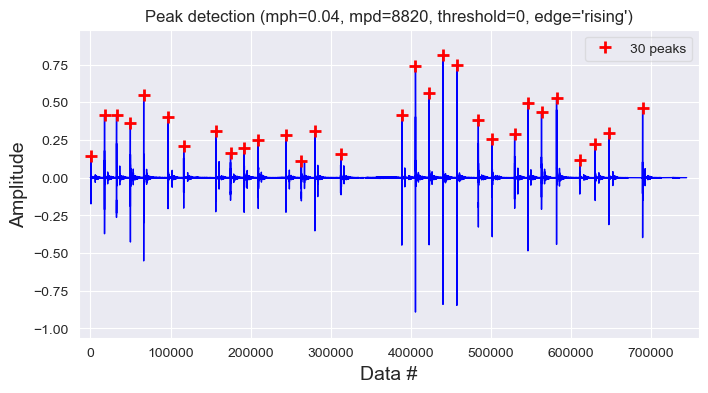

key 1
k=0.510	num_keys=31
k=0.520	num_keys=31
k=0.530	num_keys=31
k=0.540	num_keys=31
k=0.550	num_keys=30
final k=0.550	num_keys=30	peaks=30



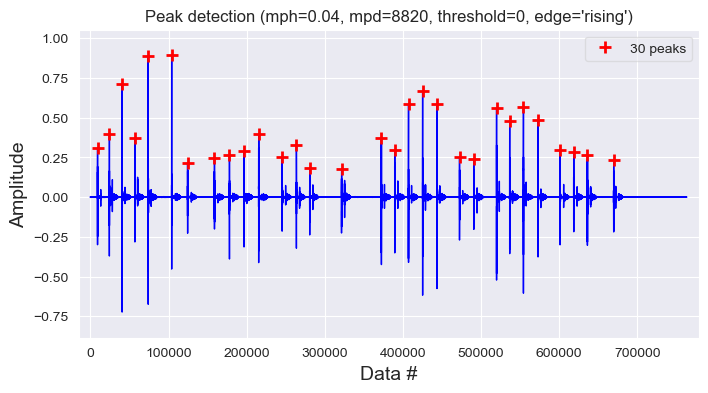

key 2
k=0.510	num_keys=31
k=0.520	num_keys=30
final k=0.520	num_keys=30	peaks=30



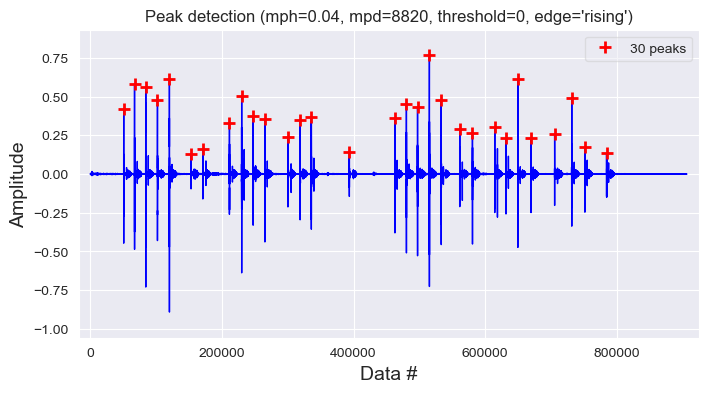

key 3
final k=0.500	num_keys=30	peaks=30



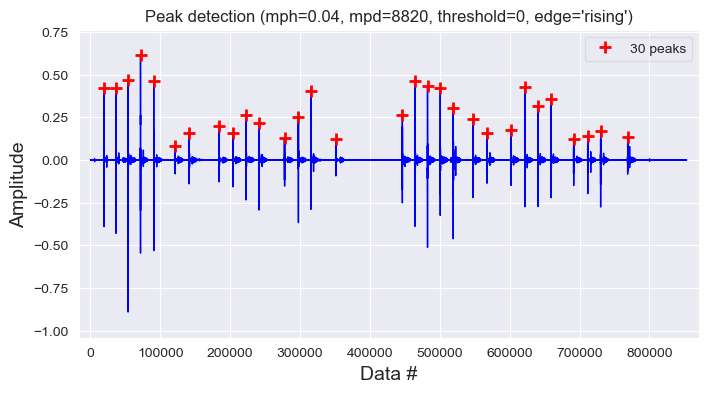

key 4
k=0.510	num_keys=30
final k=0.510	num_keys=30	peaks=30



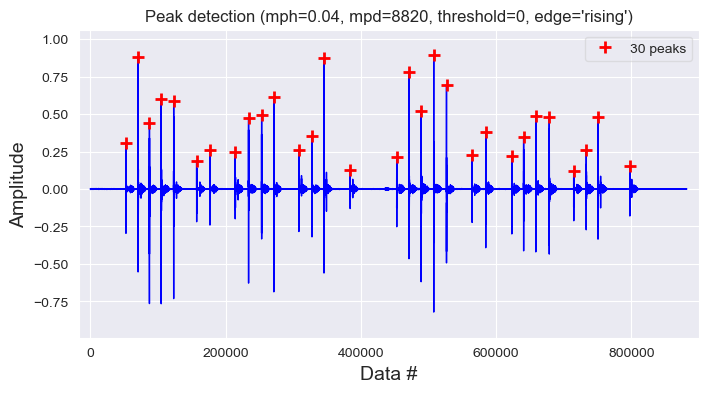

key 5
final k=0.500	num_keys=30	peaks=30



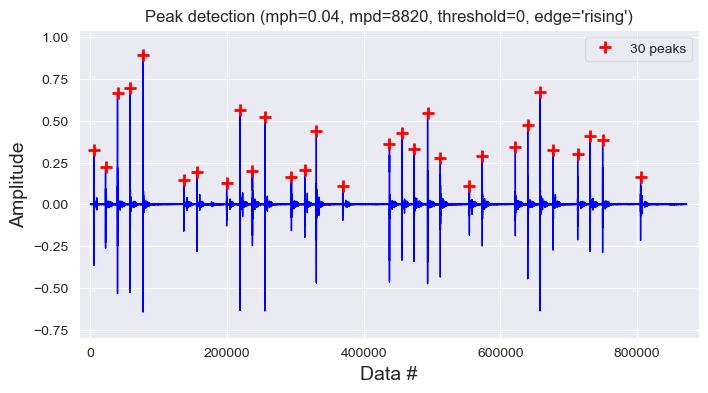

key 6
k=0.510	num_keys=30
final k=0.510	num_keys=30	peaks=30



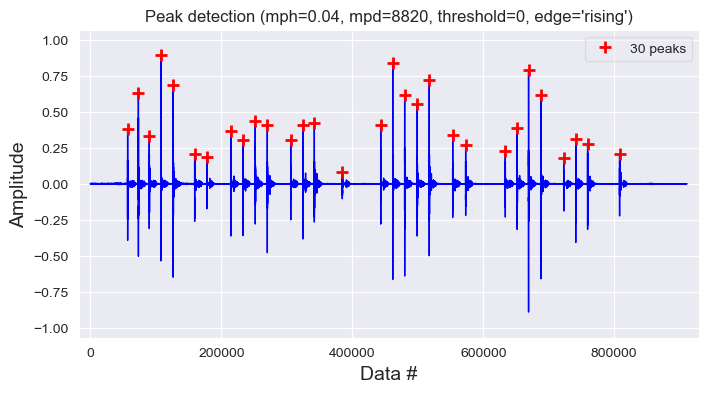

key 7
k=0.510	num_keys=30
final k=0.510	num_keys=30	peaks=30



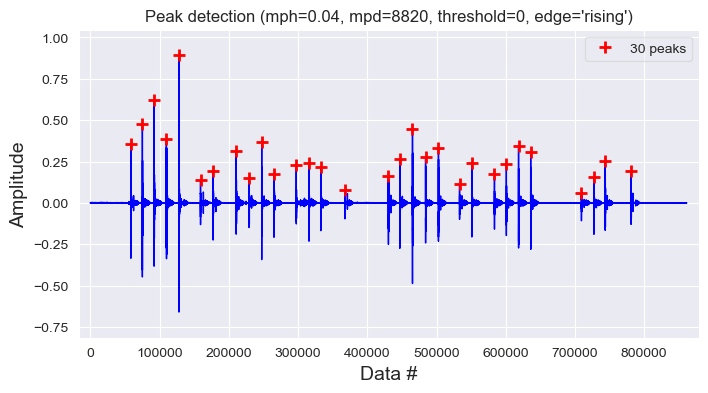

key 8
k=0.510	num_keys=31
k=0.520	num_keys=31
k=0.530	num_keys=30
final k=0.530	num_keys=30	peaks=30



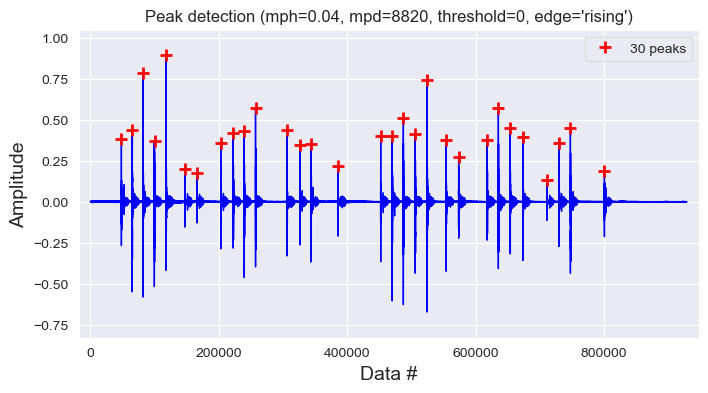

key 9
k=0.510	num_keys=31
k=0.520	num_keys=30
final k=0.520	num_keys=30	peaks=30



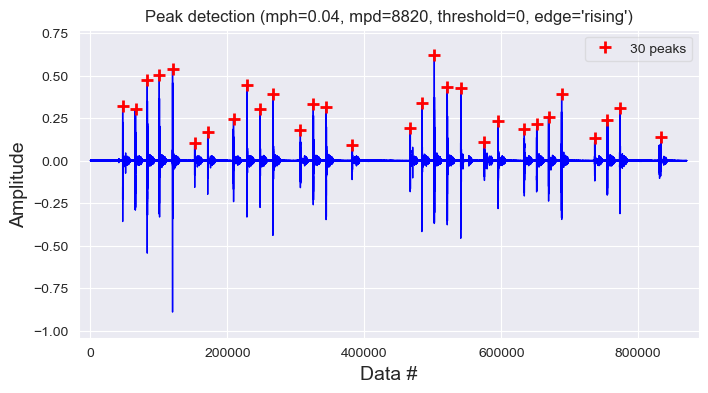

key 0
k=0.510	num_keys=31
k=0.520	num_keys=30
final k=0.520	num_keys=30	peaks=30



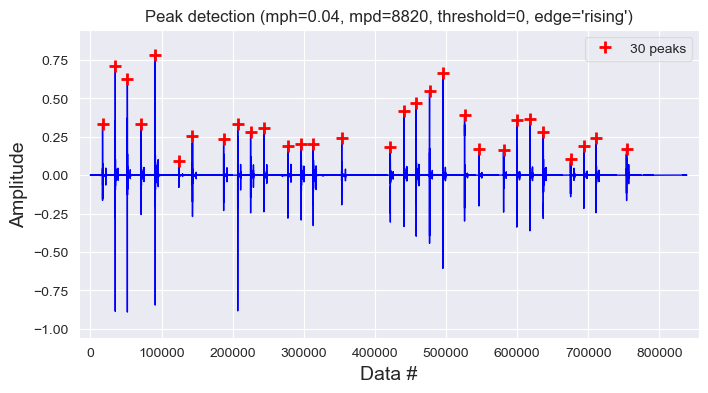

key Q
k=0.510	num_keys=31


KeyboardInterrupt: 

In [10]:
# currently used keys
curr_keys = list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM')
curr_dataset = create_dataset(curr_keys, initial_k=0.5, key_length=8820)
print(curr_dataset)

/opt/anaconda3/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


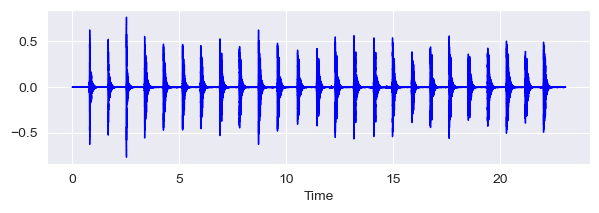

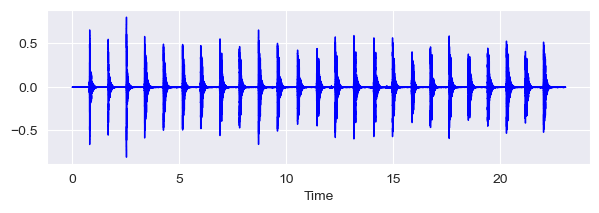

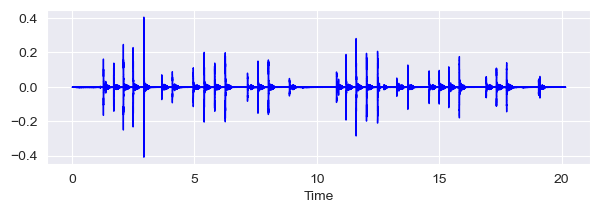

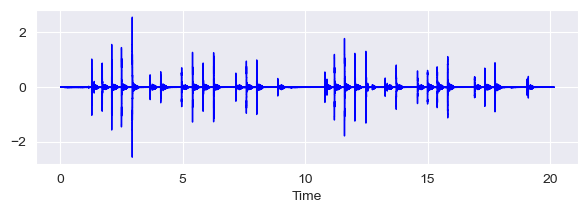

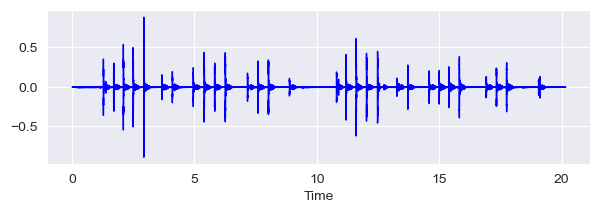

In [115]:
import soundfile as sf
import pyloudnorm as pyln

# the first onesss
data, sr = librosa.load(f'../Dataset-for-Binary/base-audio/audio_0.wav', sr=44100)
disp_waveform(data, sr=44100)
meter = pyln.Meter(sr, filter_class="Fenton/Lee 2")
loudness = meter.integrated_loudness(data)
loudness_normalized_audio = pyln.normalize.loudness(data, loudness, -23.0)
disp_waveform(loudness_normalized_audio, sr=44100)

# the second one
data, sr = librosa.load(f'../MKA datasets/All Dataset/Raw Data/0/0mac.wav', sr=44100)
disp_waveform(data, sr=44100)
meter = pyln.Meter(sr, filter_class="Fenton/Lee 2")
loudness = meter.integrated_loudness(data)
loudness_normalized_audio = pyln.normalize.loudness(data, loudness, -23.0)
disp_waveform(loudness_normalized_audio, sr=44100)
peak_normalized_audio = pyln.normalize.peak(data, -1.0)
disp_waveform(peak_normalized_audio, sr=44100)


In [60]:
# constants
N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2400, 12000

# MKA Datasets instance
samples, sr = librosa.load('../MKA datasets/All Dataset/Raw Data/0/0mac.wav', sr=44100)
print(f'Absolute samples sum: {np.sum(partition_audio(samples))}')
print(f'Samples sum: {np.sum(samples)}')
disp_waveform(samples, sr=44100)
librosa.stft(samples, n_fft=N_FFT, hop_length=HOP_LENGTH).shape
# print(f'Shape: {samples.shape}')
# disp_waveform(samples[100000:samples.shape[0]//5], title='Waveform', sr=44100)
# strokes = isolator(samples, sr, N_FFT, HOP_LENGTH, BEFORE, AFTER, 0.04, False)
# print(len(strokes))

In [61]:
# constants
N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2400, 12000

# MKA Datasets instance
samples, sr = librosa.load('../MKA datasets/All Dataset/Raw Data/0/0mac.wav', sr=44100)
print(f'Shape: {samples.shape}')
disp_waveform(samples[100000:samples.shape[0]//5], title='Waveform', sr=44100)
strokes = isolator(samples, sr, N_FFT, HOP_LENGTH, BEFORE, AFTER, 0.04, False)
print(len(strokes))

# Original Dataset
samples, sr = librosa.load('../Dataset-for-Binary/base-audio/audio_2.wav', sr=44100)
print(f'Shape: {samples.shape}')
disp_waveform(samples, title='Waveform', sr=44100)
strokes = isolator(samples, sr, N_FFT, HOP_LENGTH, BEFORE, AFTER, 0.04, False)
print(len(strokes))


In [4]:
# Constants we actually need for the task
original = True
concat = True
complete_set = list('1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-')
original_set = list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM')
if original:
    # ORIGINAL DATA SET
    MBP_AUDIO_DIR, labels, audiostr = '../Dataset-for-Binary/base-audio/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM'), 'audio_'
    keys = [audiostr + k + '.wav' for k in labels]
    N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2400, 12000
    MBP_AUDIO_DIR_2, labels_2, audiostr = '../Dataset-custom-audio/base-audio-denoised-normalized/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'), ''
    keys_2 = [audiostr + k + '.wav' for k in labels_2]
    N_FFT_2, HOP_LENGTH_2, BEFORE_2, AFTER_2 = 1024, 225, 2200, 11000
    print("Original is True")
else:
    # CUSTOM DATA SET
    MBP_AUDIO_DIR, labels, audiostr = '../Dataset-custom-audio/base-audio-denoised-normalized/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'), ''
    keys = [audiostr + k + '.wav' for k in labels]
    N_FFT, HOP_LENGTH, BEFORE, AFTER = 1024, 225, 2200, 11000
    MBP_AUDIO_DIR_2, labels_2, audiostr = '../Dataset-for-Binary/base-audio/', list('1234567890QWERTYUIOPASDFGHJKLZXCVBNM'), 'audio_'
    keys_2 = [audiostr + k + '.wav' for k in labels_2]
    N_FFT_2, HOP_LENGTH_2, BEFORE_2, AFTER_2 = 1024, 225, 2400, 12000
    print("Original is False")

# keys list
data_dict = {'Key':[], 'File':[]}
data_dict_t= {'Key':[], 'File':[]} #for custom audio testing

# device agnostic to os
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

Original is True


(513, 2257)
(507801,)


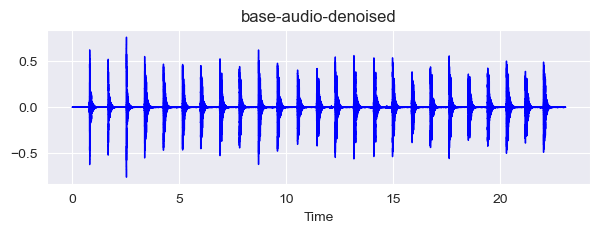

In [5]:
samples, sr = librosa.load(MBP_AUDIO_DIR+'audio_0.wav')
disp_waveform(samples, 'base-audio-denoised', sr=sr)
print(librosa.stft(samples, n_fft=1024, hop_length=225).shape)
print(samples.shape)

In [6]:
def create_dataset(n_fft, hop_length, before, after, keys, audio_dir, curr_labels, prom=0.2391, original=True):
    data_dict = {'Key':[], 'File':[]}
    for i, File in enumerate(keys):
        loc = audio_dir + File
        samples, sr = librosa.load(loc)
        show = (File[6 if original else 0] == '0')
        strokes = isolator(samples, sr, n_fft, hop_length, before, after, prom, show)
        if show:
            print(f'Length strokes: {len(strokes)}')
        label = [curr_labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)
    
    return df

Length strokes: 25


/var/folders/dr/8bpx1vc91zq76n48xvq00vkr0000gn/T/ipykernel_38463/843507350.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace = True)


hello
hello
Length strokes: 40


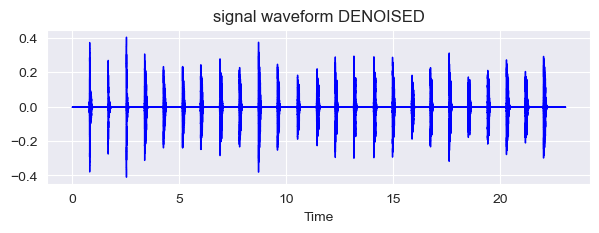

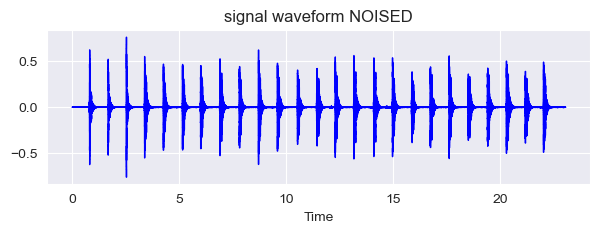

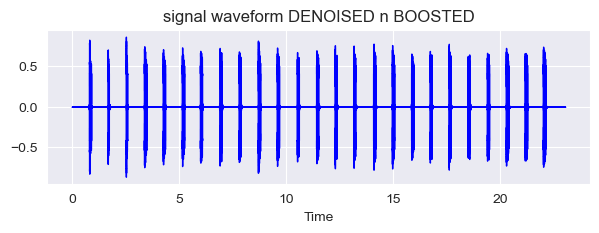

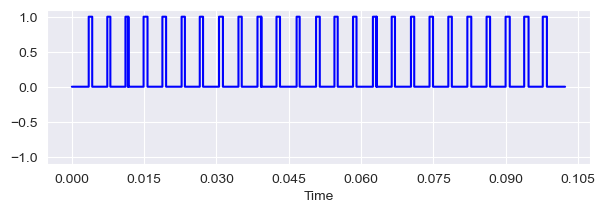

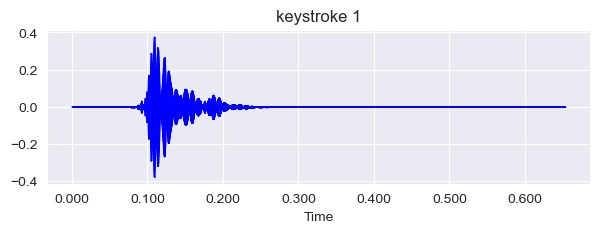

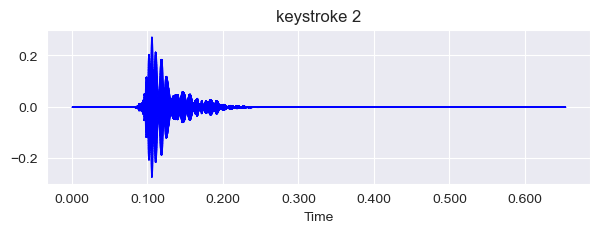

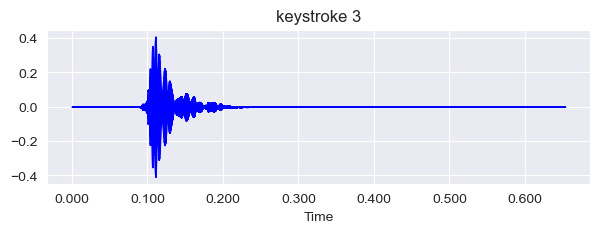

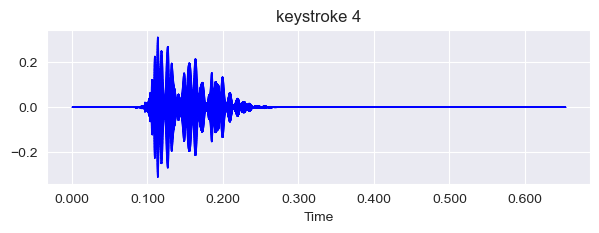

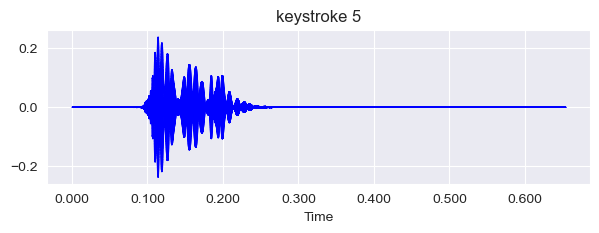

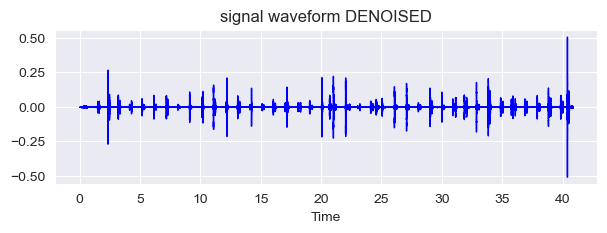

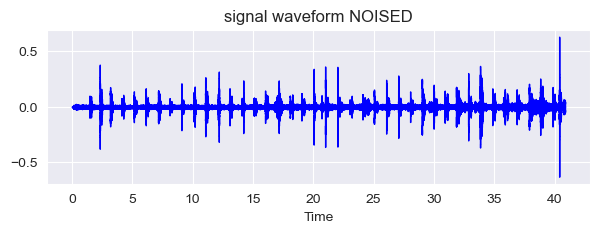

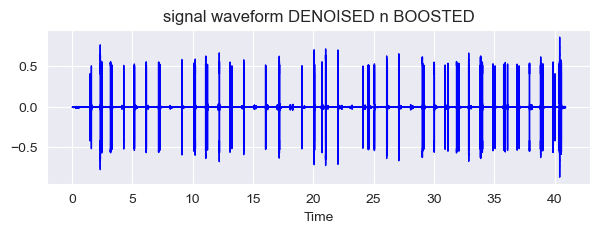

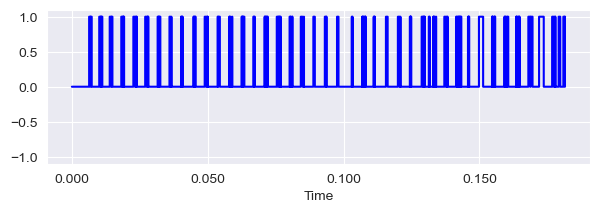

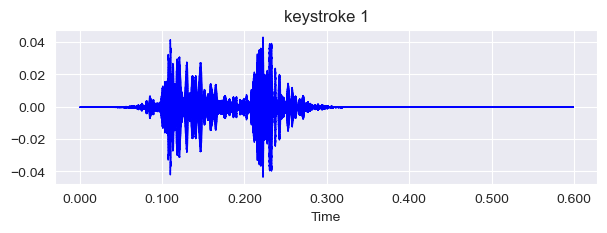

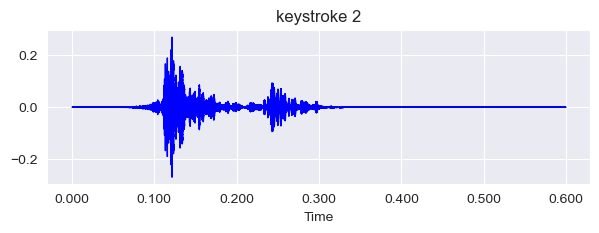

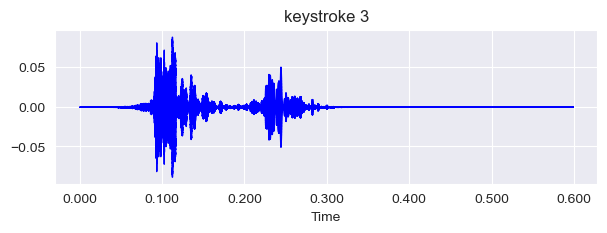

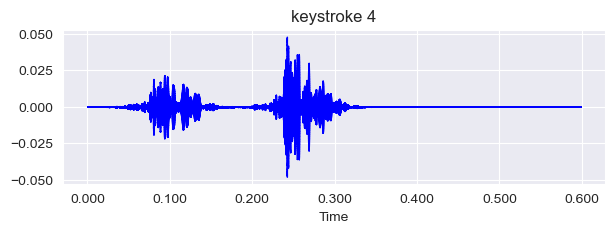

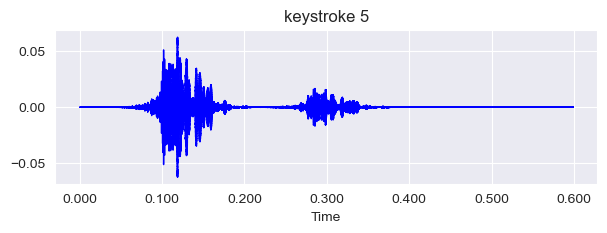

In [7]:
mbp_dataset = create_dataset(N_FFT, HOP_LENGTH, BEFORE, AFTER, keys, MBP_AUDIO_DIR, labels, prom=0.004, original=original)
if concat:
    mbp_dataset_2 = create_dataset(N_FFT_2, HOP_LENGTH_2, BEFORE_2, AFTER_2, keys_2, MBP_AUDIO_DIR_2, labels_2, prom=0.004, original=not original)
    mbp_dataset = pd.concat([mbp_dataset, mbp_dataset_2])

In [ ]:
# BOOKMARK

In [8]:
mbp_dataset

,Key,File
0,0,"[-1.9765257e-12, -7.5266117e-13, -3.2800477e-1..."
1,0,"[3.1104875e-07, 2.8876556e-07, 4.8392434e-07, ..."
2,0,"[1.5262138e-05, 1.8472152e-05, 2.0566145e-05, ..."
3,0,"[0.0005208879, 0.0005132711, 0.0005245662, 0.0..."
4,0,"[0.0026841052, 0.0026423365, 0.002146231, 0.00..."
...,...,...
1553,38,"[-6.9635644e-11, -2.5764505e-11, 2.1436986e-11..."
1554,38,"[-1.5070534e-09, -1.3474242e-09, -1.092276e-09..."
1555,38,"[-1.7647983e-08, -1.7838477e-08, -1.785552e-08..."
1556,38,"[1.2833405e-08, 1.0472381e-08, 7.562171e-09, 4..."


In [9]:
import time

def get_best_threshold(lim_start, lim_end, original):
    threshold_values = np.arange(lim_start, lim_end, 0.0005)
    max_thres_value = threshold_values[0]
    max_mean = 1
    min_rel_std = 100000
    for threshold_value in threshold_values:
        lengths = []
        for key in keys_s:
            sample, sr = librosa.load(f'{MBP_AUDIO_DIR}{"audio_" if original else ""}{key}.wav')
            lengths.append(len(isolator(sample, sr, 1024, 225, 2200, 11000, threshold_value)))
        print(f'Thres: {threshold_value:.4f}' , end=' ')
        mean = np.mean(lengths)
        rel_std = (np.std(lengths)/np.mean(lengths))*100
        if 38 <= mean <= 42:
            print(lengths)
        if rel_std < min_rel_std:
            min_rel_std = rel_std
            max_thres_value = threshold_value
            max_mean = mean
        print(f'threshold: {threshold_value:.4f}  /  mean: {mean:.2f}  /  rel std dev: {((np.std(lengths)/mean) *100):.3f}%  /  max: {np.max(lengths)}  /  min: {np.min(lengths)}')
    print(f'Min relative std: {min_rel_std:.4f} threshold value:  {max_thres_value:.4f} mean: {max_mean:.4f}')
    return max_thres_value

In [10]:
get_best_threshold(0.001, 0.2, original)

NameError: name 'keys_s' is not defined

In [11]:
import audiosegment

def get_audio_length(audio_path):
    audio = audiosegment.from_file(audio_path)
    return audio.duration_seconds

def convert_to_ms(t):
    return round(t*1000)

def get_audio_length_average(audio_path, keys):
    lengths = []
    for i, File in enumerate(keys):
        loc = audio_path + File
        length = get_audio_length(loc)
        print(f'File {loc} length: {length:2f}\n')
        lengths.append(length)
    average = np.mean(lengths)
    return convert_to_ms(average)

In [12]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audioDataset = np.array(audio_samples, dtype = object)
print(audio_samples[0].shape)
mfcc = librosa.feature.mfcc(y=audio_samples[0], sr=44100) # shape: (n_mfcc, t)
print(mfcc.shape)
# labels = np.array(labels)

(14400,)
(20, 29)


In [13]:
def time_shift(samples):
    samples = samples.flatten()
    shift = int(len(samples) * 0.4) #Max shift (0.4)
    random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
    data_roll = np.roll(samples, random_shift)
    return data_roll

def masking(samples):
    num_mask = 2
    freq_masking_max_percentage=0.10
    time_masking_max_percentage=0.10
    spec = samples
    mean_value = spec.mean()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = mean_value

        time_percentage = random.uniform(0.0, time_masking_max_percentage)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = mean_value
    return spec

In [14]:
from skimage.transform import resize

class ToMelSpectrogram:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=1024, hop_length=225)
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)
        return torch.tensor(mel_spec_resized)


class ToMelSpectrogramMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=n_fft, hop_length=hop_length)
        mel_spec = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec))
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

        return torch.tensor(mel_spec_resized)


class ToMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')
        
        mfcc_spec = librosa.feature.mfcc(y=samples, sr=44100)
        mfcc_spec = np.transpose(mfcc_spec)
        return torch.tensor(mfcc_spec)


In [15]:
transform = Compose([ToMelSpectrogram()])
transform_mfcc = Compose([ToMfcc()])

In [16]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audio_samples_new = audio_samples.copy() # audio samples CNN
print(len(audio_samples))

for i, sample in enumerate(audio_samples):
    audio_samples_new.append(time_shift(sample))
    labels.append(labels[i])

# convert labels to a numpy array
labels = np.array(labels)
print(len(audio_samples_new))
print(len(labels))

2457
4914
4914


In [17]:
audioDatasetFin, audioDatasetFinMasking, audioDatasetMfcc, audioDatasetMfccMasking = [], [], [], []

for i in range(len(audio_samples_new)):
    transformed_sample = transform(audio_samples_new[i])
    transformed_mfcc = transform_mfcc(audio_samples_new[i])
    
    # CoAtNet part
    audioDatasetFin.append((transformed_sample, labels[i]))
    audioDatasetFinMasking.append((masking(transformed_sample), labels[i]))
    
    # masking part
    audioDatasetMfcc.append((transformed_sample, transformed_mfcc, labels[i]))
    audioDatasetMfccMasking.append((masking(transformed_sample), transformed_mfcc, labels[i]))


0


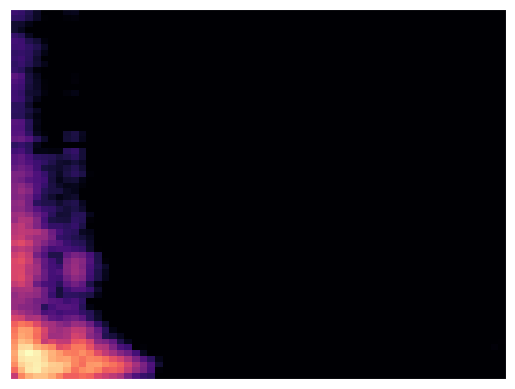

In [18]:
i = 6
mel_spec = librosa.feature.melspectrogram(y=audio_samples[i], sr=44100, n_mels=64, n_fft=1024, hop_length=225)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max))
print(labels[i])

In [19]:
# check for lengths of datasets
len(audioDatasetMfcc), len(audioDatasetMfcc + audioDatasetMfccMasking), len(audioDatasetFin), len(audioDatasetFin + audioDatasetFinMasking)

(4914, 9828, 4914, 9828)

In [20]:
import time
from sklearn.base import BaseEstimator

class MfccLSTM(nn.Module, BaseEstimator):
    def __init__(self, num_epochs=500, patience=15):
        super(MfccLSTM, self).__init__()        
        self.num_epochs = num_epochs
        self.patience = patience
        
        hidden_size = 32
        input_size = 20
        dropout = 0.2 
        num_classes = 36
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.LazyLinear(128)
        self.final_lstm = nn.LSTM(1, 128, batch_first=True, proj_size=64)
        
        self.fc = nn.LazyLinear(num_classes)
    
    def forward(self, images, sequences):
        # must return shape (batch_size, num_classes) 
        # batch_size: right now is 16
        # num_classes: right now is 36
        x1 = self.conv(images)
        # print(f'input of first lstm: {sequences.shape[1:]}')
        out1, _ = self.lstm(sequences)
        out1_dp = self.dropout(out1)
        # print(f'output of first lstm: {out1_dp.shape[1:]}')
        # print(f'input of second lstm: {out1_dp[:, -1, :].shape[1:]}')
        out2, _ = self.lstm2(out1_dp[:, -1, :])
        out2_dp = self.dropout(out2)
        # print(f'output of second lstm: {out2_dp.shape[1:]}')
        x2 = self.fc2(self.fc1(out2_dp))
        x3 = torch.cat((x1, x2), 1)
        # print(f'output of concatenation: {x3.shape[1:]}')
        # x4 = self.fc3(x3)
        # # print(f'input final lstm: {x4[:,-1,:].shape[1:]}')
        # print(f'x4.shape: {x4.shape[1:]}')
        # x_final = self.final_lstm(x4)
        # # x = self.fc(final_out[:, -1, :])
        x = self.fc(x3)
        return x
    
    def fit(self, X, y):
        self._optimizer = optim.Adam(self.parameters(), lr=5e-4)
        # same training method but now inside the class
        model = self.to(device)
        
        # loss criterion
        criterion = nn.CrossEntropyLoss()
        
        # concatenate so it has the same shape as before
        dataset = np.concatenate((X, y), axis=1)
        train_set, val_set = train_test_split(dataset, test_size=0.2)
        train_loader = DataLoader(train_set, batch_size=16)
        val_loader = DataLoader(val_set, batch_size=16)
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(self.num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, sequences, labels in train_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                self._optimizer.zero_grad()
        
                # converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images, sequences)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)
        
                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                self._optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            
            for images, sequences, labels in val_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
        
                outputs = model(images, sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= self.patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        return self
        
    def predict(self, X):
        images_test_set = [t[0] for t in X]
        sequences_test_set = [t[1] for t in X]
        
        images = torch.stack(images_test_set)
        sequences = torch.stack(sequences_test_set)
        images = images.to(device)
        sequences = sequences.to(device)
        model = self.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(images, sequences)
            _, predicted = torch.max(outputs.data, 1)
    
        pred = []
        keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'
        phrase = predicted.tolist()
        for i in range(len(phrase)):
            pred.append(keyss[phrase[i]])
        pred_df = pd.DataFrame(pred)
        return np.squeeze(pred_df.to_numpy().T)

In [21]:
from coatnet import CoAtNet as CoAtNetImp

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D

class CoAtNet(nn.Module, BaseEstimator):
    def __init__(self, num_epochs=500, patience=200):
        super(CoAtNet, self).__init__()    
        self.keys = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'
        self.model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(self.keys))
        self.num_epochs = num_epochs
        self.patience = patience
    
    def forward(self, x):
        return self.model(x)
    
    def fit(self, X, y):
        # concatenate so it has the same shape as before
        dataset = [(X[i], y[i]) for i in range(np.array(X).shape[0])]
        # dataset = np.concatenate((X, y), axis=1)
        train_set, val_set = train_test_split(dataset, test_size=0.2)
        train_loader, val_loader = DataLoader(train_set, batch_size=16), DataLoader(val_set, batch_size=16)

        # Initialize model, optimizer, and loss function
        self._optimizer = optim.Adam(self.model.parameters(), lr=5e-4)

        # same training method but now inside the class
        model = self.model.to(device)
        
        # loss criterion
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(self.num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                self._optimizer.zero_grad()
        
                # converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)
        
                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                self._optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
        
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 1 == 0:
                print(f"Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= self.patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        return self
    
    def predict(self, X):
        argnames=["x"]
        fin_dict = {}
        # create the list with each of the ith range tuples
        for i in range(len(X[0])-1):
            fin_dict[argnames[i]] = [t[i] for t in dataset]
            
        # torch.stack each one of the lists
        for key in fin_dict.keys():
            fin_dict[key] = torch.stack(fin_dict[key]).to(device)
        
        X = torch.tensor(np.array(X)).to(device)
        
        # model specifying
        model = self.model.to(device)
        model.eval()
        
        with torch.no_grad():
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
        
        pred = []
        # phrase = predicted.tolist()
        # for i in range(len(phrase)):
        #     pred.append(self.keys[phrase[i]])
        # 
        # pred_df = pd.DataFrame(pred)
        # return np.squeeze(pred_df.to_numpy().T)
        return predicted.tolist()

In [22]:
from sklearn.metrics import make_scorer

dataset = audioDatasetFin + audioDatasetFinMasking
X = [t[0] for t in audioDatasetFin]
X_masking = [t[0] for t in audioDatasetFinMasking]
y = [t[1] for t in audioDatasetFin]
y_masking = [t[1] for t in audioDatasetFinMasking]
print(np.array(X).shape)
# first_el = dataset[0][0]
print(np.array(y+y_masking).shape)

param_grid = {
    'num_epochs': [500, 700, 1100],
    # 'patience': [55, 75, 100],
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0.0),
}

grid_search = GridSearchCV(CoAtNet(), param_grid, cv=5, scoring=scoring, refit=False, verbose=3)
# model = CoAtNet(patience=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
grid_search.fit(X_train + X_masking, y_train + y_masking)
print(np.array(X_train).shape)
print(np.array(y_train).shape)
# print(np.array(dataset).shape)
# print(np.concatenate((X_train, y_train), axis=3).shape)
# model.fit(X_train+X_masking, y_train+y_masking)
# print(f'Prediction: {model.predict(np.array(X_test)).shape}')
# final_labels_set = [original_set[ind] for ind in y_test]
# print(f'Labels: {np.array(final_labels_set).shape}')

(4914, 1, 64, 64)
(9828,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch [1/500], Train Loss: 3.6788, Train Accuracy: 0.0929, Val Accuracy: 0.1455, Iter Time: 20.34s
Epoch [2/500], Train Loss: 2.8430, Train Accuracy: 0.2046, Val Accuracy: 0.2083, Iter Time: 18.75s
Epoch [3/500], Train Loss: 2.3701, Train Accuracy: 0.3060, Val Accuracy: 0.2655, Iter Time: 18.76s
Epoch [4/500], Train Loss: 2.0437, Train Accuracy: 0.3961, Val Accuracy: 0.3799, Iter Time: 19.05s
Epoch [5/500], Train Loss: 1.7625, Train Accuracy: 0.4767, Val Accuracy: 0.3814, Iter Time: 19.27s
Epoch [6/500], Train Loss: 1.5713, Train Accuracy: 0.5364, Val Accuracy: 0.3983, Iter Time: 18.41s
Epoch [7/500], Train Loss: 1.4146, Train Accuracy: 0.5758, Val Accuracy: 0.4258, Iter Time: 17.85s
Epoch [8/500], Train Loss: 1.2774, Train Accuracy: 0.6134, Val Accuracy: 0.4167, Iter Time: 17.99s
Epoch [9/500], Train Loss: 1.2044, Train Accuracy: 0.6398, Val Accuracy: 0.4795, Iter Time: 18.00s
Epoch [10/500], Train Loss: 1.0427, Train Accuracy: 0.6922, Val Accuracy: 0.4873, Iter Time: 18.06s
Epoch [11

In [24]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

sorted_df = cv_results_df.sort_values(by=['rank_test_accuracy'])

for ind, row in sorted_df.iterrows():
    print(f'Rank: {row["rank_test_accuracy"]}')
    print(f'Params: {row["params"]}')
    print(f'Test accuracy: {row["mean_test_accuracy"]:.3f}', end=" / ")
    print(f'F1 Weighted: {row["mean_test_f1_weighted"]:.3f}', end=" / ")
    print(f'Recall Weighted: {row["mean_test_recall_weighted"]:.3f}', end=" / ")
    print(f'Precision Weighted: {row["mean_test_precision_weighted"]:.3f}', end="\n\n")

grid_search.cv_results_

Rank: 1
Params: {'num_epochs': 700}
Test accuracy: 0.712 / F1 Weighted: 0.723 / Recall Weighted: 0.712 / Precision Weighted: 0.779

Rank: 2
Params: {'num_epochs': 1100}
Test accuracy: 0.675 / F1 Weighted: 0.685 / Recall Weighted: 0.675 / Precision Weighted: 0.759

Rank: 3
Params: {'num_epochs': 500}
Test accuracy: 0.669 / F1 Weighted: 0.677 / Recall Weighted: 0.669 / Precision Weighted: 0.760



{'mean_fit_time': array([12592.39807878, 13897.4721148 , 14630.5563746 ]),
 'std_fit_time': array([3545.08433935, 4308.60701418, 5600.44545535]),
 'mean_score_time': array([ 4.90888162,  7.26315198, 12.38287339]),
 'std_score_time': array([3.50647398, 4.20092564, 1.98491523]),
 'param_num_epochs': masked_array(data=[500, 700, 1100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'num_epochs': 500}, {'num_epochs': 700}, {'num_epochs': 1100}],
 'split0_test_accuracy': array([0.70830978, 0.75579423, 0.70265687]),
 'split1_test_accuracy': array([0.75692482, 0.75240249, 0.6941775 ]),
 'split2_test_accuracy': array([0.64556246, 0.68004522, 0.69361221]),
 'split3_test_accuracy': array([0.60542679, 0.6625212 , 0.63143019]),
 'split4_test_accuracy': array([0.6302996 , 0.71000565, 0.65347654]),
 'mean_test_accuracy': array([0.66930469, 0.71215376, 0.67507066]),
 'std_test_accuracy': array([0.05543313, 0.0374791 , 0.02771518]),
 'rank_te

In [ ]:
# cv_results_df = pd.DataFrame(grid_search.cv_results_)
# cv_results_df = cv_results_df[["params", "mean_test_accuracy", "rank_test_accuracy", "mean_test_f1_weighted", "rank_test_f1_weighted", "mean_test_precision_weighted", "rank_test_precision_weighted", 
#  "mean_test_recall_weighted", "rank_test_recall_weighted"]]
# cv_results_df

# param_grid = {
#     'num_epochs': [500, 700, 1100],
#     'patience': [55, 75, 100],
# }
# 
# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
#     'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0),
#     'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0.0),
# }
# 
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit=False, verbose=3)
# grid_search.fit(X, y)
# param_grid = {
#     'num_epochs': [500, 700, 1100],
#     # 'patience': [10, 15, 20, 30, 50, 100],
# }
# grid_search = GridSearchCV(MfccLSTM(), param_grid, cv=5, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False, verbose)
# 
# dataset = audioDatasetMfcc + audioDatasetMfccMasking
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
# # print(X_train.shape)
# grid_search.fit(X_train, y_train)

In [ ]:
sorted_df = cv_results_df.sort_values(by=['rank_test_accuracy'])

for ind, row in sorted_df.iterrows():
    print(f'Rank: {row["rank_test_accuracy"]}')
    print(f'Params: {row["params"]}')
    print(f'Test accuracy: {row["mean_test_accuracy"]:.3f}', end=" / ")
    print(f'F1 Weighted: {row["mean_test_f1_weighted"]:.3f}', end=" / ")
    print(f'Recall Weighted: {row["mean_test_recall_weighted"]:.3f}', end=" / ")
    print(f'Precision Weighted: {row["mean_test_precision_weighted"]:.3f}', end="\n\n")

# best_params_list = grid_search.cv_results_['rank_test_accuracy']
# print(grid_search.cv_results_)
# print(best_params_list)
# print(best_params_list)
# print(best_params_list)
# print(grid_search.cv_results_["mean_test_accuracy"])
# 
# for i in best_params_list:
#     print(f'Parameter {i-1}: {grid_search.cv_results_["params"][i-1]}')
#     print(f'Mean Test accuracy: {grid_search.cv_results_["mean_test_accuracy"][i-1]:.3f}')
#     print(f'Std Test accuracy: {grid_search.cv_results_["std_test_accuracy"][i-1]:.3f}')
#     # print(f'Mean F1 weighted: {grid_search.cv_results_["mean_test_f1_weighted"][i-1]:.3f}')
#     # print(f'Mean Recall weighted: {grid_search.cv_results_["mean_test_recall_weighted"][i-1]:.3f}')
#     # print(f'Mean Precision weighted: {grid_search.cv_results_["mean_test_precision_weighted"][i-1]:.3f}')
#     print()

In [ ]:
dataset = audioDatasetFin + audioDatasetFinMasking
# X = np.array(dataset)[:, :1]
# y = np.array(dataset)[:, 2]
# print(X.shape)
# print(dataset[0])
X = [t[0] for t in dataset]
y = [t[1] for t in dataset]

param_grid = {
    'num_epochs': [500, 700, 1100],
    'patience': [10, 15, 20, 30, 50, 100],
}

grid_search = GridSearchCV(CoAtNet(), param_grid, cv=10, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False, verbose=3)

dataset = audioDatasetMfcc + audioDatasetMfccMasking
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y),test_size=0.2)

                                                    
print(X_train.shape)
print(y_train.shape)
grid_search.fit(X_train, y_train)

In [ ]:
param_grid = {
    'num_epochs': [500, 700, 1100],
    'patience': [10, 15, 20, 30, 50, 100],
}
grid_search = GridSearchCV(MfccLSTM(), param_grid, cv=10, scoring=['accuracy', 'f1', 'precision', 'recall'], refit=False)

dataset = audioDatasetMfcc + audioDatasetMfccMasking
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
# print(X_train.shape)
grid_search.fit(X_train, y_train)

In [ ]:
# Model architecture
class CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import time

def train_cnnlstm_with_cross_val(dataset, num_epochs, model_name, device, num_classes=36, patience=10, random_state=42, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold+1}/{n_splits}')
        
        # Split the dataset into training and validation sets
        train_set = Subset(dataset, train_idx)
        val_set = Subset(dataset, val_idx)
        train_loader = DataLoader(train_set, batch_size=16)
        val_loader = DataLoader(val_set, batch_size=16)
        
        # Initialize model, optimizer, and loss function
        model = MfccLSTM(input_size=20, hidden_size=32, num_classes=num_classes, output_size=64)
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=5e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc, epochs_no_imp = 0, 0
        train_accuracies, val_accuracies = [], []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            tic = time.perf_counter()
            
            for images, sequences, labels in train_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                #converting labels to Long to avoid error "not implemented for Int"
                labels = labels.long()
                
                # Forward pass
                outputs = model(images, sequences)
                loss = criterion(outputs, labels)
                epoch_train_loss += loss.item() * images.size(0)

                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
                # Backward pass
                loss.backward()
                optimizer.step()
            
            toc = time.perf_counter()
            time_taken = toc - tic
            
            epoch_train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            # Evaluation of the model
            model.eval()
            total, correct = 0, 0
            for images, sequences, labels in val_loader:
                images = images.to(device)
                sequences = sequences.to(device)
                labels = labels.to(device)

                outputs = model(images, sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
                
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                epochs_no_imp = 0
                best_model_state = model.state_dict()  # Save the best model
            else:
                epochs_no_imp += 1
            if epochs_no_imp >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                model.load_state_dict(best_model_state)  # Load the best model
                break
        
        fold_results.append(best_val_acc) 
        print(f'Fold {fold+1} Best Validation Accuracy: {best_val_acc:.4f}')
    torch.save(model.state_dict(), model_name)
    print(f'Training final results: {fold_results}')
    
    return num_epochs, np.average(fold_results)

In [ ]:
import time
from coatnet import CoAtNet as CoAtNetImp

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D

def train_coatnet_with_cross_val(dataset, num_epochs, model_name, device_external, num_classes=36, patience=10, random_state=42):
    train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=random_state)
    train_loader, val_loader = DataLoader(train_set, batch_size=16), DataLoader(val_set, batch_size=16)
    
    # Initialize model, optimizer, and loss function
    model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=num_classes)
    device = torch.device(device_external) #default to mps
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc, epochs_no_imp = 0, 0
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        tic = time.perf_counter()
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
    
            labels = labels.long() # converting labels to Long to avoid error "not implemented for Int"
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() * images.size(0)
    
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        toc = time.perf_counter()
        time_taken = toc - tic
        
        epoch_train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Evaluation of the model
        model.eval()
        total, correct = 0, 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Iter Time: {time_taken:.2f}s")
            
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_no_imp = 0
            best_model_state = model.state_dict()  # Save the best model
        else:
            epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            model.load_state_dict(best_model_state)  # Load the best model
            break
            
    torch.save(model.state_dict(), model_name)
    return epoch+1, best_val_acc

In [ ]:
def predict_mfcc(dataset, model_path, device_external):
    images_test_set = [t[0] for t in dataset]
    sequences_test_set = [t[1] for t in dataset]
    
    images = torch.stack(images_test_set)
    sequences = torch.stack(sequences_test_set)
    device = torch.device(device_external) #default to mps
    images = images.to(device)
    sequences = sequences.to(device)
    model = MfccLSTM(input_size=20, hidden_size=32, num_classes=36, output_size=64)
    model = model.to(device)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    
    with torch.no_grad():
        outputs = model(images, sequences)
        _, predicted = torch.max(outputs.data, 1)

    pred = []
    keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'
    phrase = predicted.tolist()
    for i in range(len(phrase)):
        pred.append(keyss[phrase[i]])

    pred_df = pd.DataFrame(pred)
    return pred_df


def predict(dataset, model_obj, argnames, model_path, device_external):
    fin_dict = {}

    # create the list with each of the ith range tuples
    for i in range(len(dataset[0])-1):
        fin_dict[argnames[i]] = [t[i] for t in dataset]
        
    # specify device: default to mps
    device = torch.device(device_external) 
    
    # torch.stack each one of the lists
    for key in fin_dict.keys():
        fin_dict[key] = torch.stack(fin_dict[key]).to(device)
    
    # model specifying
    model = model_obj.to(device)
    model.load_state_dict(torch.load(model_path,map_location=device))
    model.eval()
    
    with torch.no_grad():
        outputs = model(**fin_dict)
        _, predicted = torch.max(outputs.data, 1)
    
    pred = []
    keyss = '1234567890QWERTYUIOPASDFGHJKLZXCVBNMÑ+-'

    phrase = predicted.tolist()
    for i in range(len(phrase)):
        pred.append(keyss[phrase[i]])

    pred_df = pd.DataFrame(pred)
    return pred_df

In [ ]:
def save_csv(model_name, num_epochs, description, accuracy, precision, recall, f1_score):
    csv_file_path = 'model_comparison.csv'
    
    # Read the existing CSV file into a DataFrame
    try:
        df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        # If the file does not exist, create an empty DataFrame with the correct columns
        df = pd.DataFrame(columns=['Datetime', 'Name', 'Epochs', 'Description', 'Accuracy', 'Precision', 'Recall', 'F1'])
        
    # Data to append
    current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Remove newline characters from the description
    description = description.replace('\n', ' ').replace('\r', ' ')
    
    # Create a new column with the relevant information
    new_data = {
        'Datetime': [current_datetime],
        'Name': [model_name],
        'Epochs': [num_epochs],
        'Description': [description],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1_score],
    }
    
    new_df = pd.DataFrame(new_data)
    
    df = pd.concat([df, new_df], ignore_index=True)
    
    # Save the updated DataFrame back to the CSV file
    df.to_csv(csv_file_path, index=False)

In [ ]:
# current random state to split the dataset
random_state = 45
curr_day = datetime.today().strftime('%Y-%m-%d')
curr_time = datetime.today().strftime("%H:%M:%S")
datasets = [audioDatasetFin]
patience = 15
torch.manual_seed(random_state)

for dataset in datasets:
    # TRAIN PART
    train_final_set, test_set = train_test_split(dataset, test_size=0.2, random_state=random_state)
    num_epochs = 3
    if dataset is audioDatasetMfcc:
        for curr_dataset in [dataset, dataset + audioDatasetMfccMasking]:
            main_architecture = f"CNN_LSTM{'_masking' if curr_dataset != audioDatasetMfcc else ''}"
            # Current train function
            train_function = train_cnnlstm_with_cross_val
            model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(keys_2), output_size=64)
            params_array = ["images", "sequences"]
            description = f"2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. Dataset using time shift and masking. {'Original dataset' if original else 'Custom dataset'}. {'Masking Used' if dataset == audioDatasetMfccMasking else 'No Masking'}. Patience={patience}. Random_state={random_state}"
            model_name = f"model_multiclass_{num_epochs}_{main_architecture}_{curr_day}_{curr_time}{'_custom' if not original and not concat else '_concat' if concat else '_original'}.pth"
            print(f'CURRENT MODEL: {model_name}:')
            real_num_epochs, best_val_acc = train_function(curr_dataset, num_epochs, model_name, device, num_classes=len(complete_set if not original or concat else original_set), patience=patience, random_state=random_state)
            # PREDICT PART
            prediction = predict(test_set, model, params_array, model_name, device)
            labels_set = [t[-1] for t in test_set]
            final_labels_set = [complete_set[ind] for ind in labels_set]
                
            # Metrics
            accuracy = accuracy_score(final_labels_set, prediction[0])
            precision = precision_score(final_labels_set, prediction[0], average='macro')
            recall = recall_score(final_labels_set, prediction[0], average='macro')
            f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
            
            # Save csv data for later comparison
            # save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)
            
            # Final results
            print(f"Model: {model_name}")
            print(description)
            print(f"Epochs: {num_epochs}")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print(f"Best val accuracy: {best_val_acc:.3f}")
    elif dataset is audioDatasetFin:
        for curr_dataset in [dataset, dataset + audioDatasetFinMasking]:
            main_architecture = f"CoAtNetImp{'_masking' if curr_dataset != audioDatasetFin else ''}"
            # Current train function
            train_function = train_coatnet_with_cross_val
            model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(original_set))
            params_array = ["x"]
            description = f"Imported CoAtNet model, with 2 Conv layers and then 2 Attention layers followed by a fully connected layer. {'Original dataset' if original else 'Custom dataset'}. {'Masking Used' if dataset == audioDatasetFinMasking else 'No masking'}. Patience={patience}. Random_state={random_state}"
            model_name = f"model_multiclass_{num_epochs}_{main_architecture}_{curr_day}_{curr_time}{'_custom' if not original and not concat else '_concat' if concat else '_original'}.pth"
            print(f'CURRENT MODEL: {model_name}:')
            real_num_epochs, best_val_acc = train_function(curr_dataset, num_epochs, model_name, device, num_classes=len(complete_set if not original or concat else original_set), patience=patience, random_state=random_state)
            # PREDICT PART
            prediction = np.squeeze(predict(test_set, model, params_array, model_name, device).to_numpy().T)
            print(f'Prediction.shape: {prediction.shape}')
            labels_set = [t[-1] for t in test_set]
            final_labels_set = [complete_set[ind] for ind in labels_set]
            print(f'final_labels_set.shape: {np.array(final_labels_set).shape}')
                
            # # Metrics
            # accuracy = accuracy_score(final_labels_set, prediction[0])
            # precision = precision_score(final_labels_set, prediction[0], average='macro')
            # recall = recall_score(final_labels_set, prediction[0], average='macro')
            # f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
            
            # Save csv data for later comparison
            # save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)
            
            # Final results
            print(f"Model: {model_name}")
            print(description)
            print(f"Epochs: {num_epochs}")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print(f"Best val accuracy: {best_val_acc:.3f}")

In [ ]:

grid_search = GridSearchCV(CoAtNetImp, {})

In [ ]:
train_final_set, test_set = train_test_split(audioDatasetMfcc, test_size=0.2, random_state=1)

model_name = "model_multiclass_500_CNN_LSTM_masking_2024-09-08.pth"
# model_name = "model_multiclass_500_CoAtNetImp_2024-09-08.pth"
# model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(complete_set))
model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(complete_set), output_size=64)
# arg_names = ["x"]
arg_names = ["images", "sequences"]
prediction = predict(test_set, model, arg_names, model_name, device)
labels_set = [t[-1] for t in test_set]
final_labels_set = pd.Series([complete_set[ind] for ind in labels_set])
print("PREDICTION")
print(prediction[0])
print("FINAL LABELS SET")
print(final_labels_set)
# Metrics
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save csv data for later comparison
# save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)

# Final results
print(f"Model: {model_name}")
# print(description)
# print(f"Epochs: {num_epochs}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
# print(f"Best val accuracy: {best_val_acc:.3f}")

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for name in ["model_multiclass_500_CNN_LSTM_2024-09-08.pth", "model_multiclass_500_CNN_LSTM_masking_2024-09-08.pth"]:
        
    train_final_set, test_set = train_test_split(audioDatasetMfcc, test_size=0.2, random_state=5)
    
    # model_name = "model_multiclass_500_CoAtNetImp_masking_2024-09-08.pth"
    model_name = "model_multiclass_500_CNN_LSTM_2024-09-08.pth"
    # model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=len(keys_2))
    model = MfccLSTM(input_size=20, hidden_size=32, num_classes=len(keys_2), output_size=64)
    # arg_names = ["x"]
    arg_names = ["images", "sequences"]
    prediction = predict(test_set, model, arg_names, name, device)
    labels_set = [t[-1] for t in test_set]
    final_labels_set = [keys_2[ind] for ind in labels_set]
    
    # Metrics
    accuracy = accuracy_score(final_labels_set, prediction[0])
    precision = precision_score(final_labels_set, prediction[0], average='macro')
    recall = recall_score(final_labels_set, prediction[0], average='macro')
    f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')
    
    # Generate confusion matrix
    cm = confusion_matrix(final_labels_set, prediction[0])
    
    # Plot confusion matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 8})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")


In [ ]:
# PREDICTION PART

# All metrics are calculated from the model with the best validation accuracy
# model = MfccLSTM(input_size=20, hidden_size=32, num_classes=21, output_size=64)
model = CoAtNetImp((64, 64), 1, num_blocks, channels, num_classes=21)
keys_s = '123456789-ABCDEFGHIJ+'

# prediction = predict(test_set, model, ["images", "sequences"],model_name, device)
prediction = predict(test_set, model, ["x"],model_name, device)
# prediction = predict(test_set, model, main_architecture, model_name, random_state)
# prediction = predict_mfcc(test_set, model_name, device)
labels_set = [t[-1] for t in test_set]
final_labels_set = [keys_s[ind] for ind in labels_set]
print(list(prediction[0])[15:25])
print(final_labels_set[15:25])

# Metrics calculation
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save in csv file
# description = "2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. Dataset using time shift and masking. Using now dataset of 40 audio samples "
description = "Imported CoAtNet model, with 2 Conv layers and then 2 Attention layers followed by a fully connected layer. Patience=10. Testing recently recorded denoised-normalized audio, part 2 to see if it is working. did 36 epochs. 21 keys recorded"
save_csv(model_name, int(real_num_epochs), description, accuracy, precision, recall, f1)

# Print results
print("Final Results!")
print(f"Model: {model_name}")
print(description)
print(f"Epochs: {num_epochs}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Best val accuracy: {best_val_acc:.3f}")

In [ ]:
# prediction = predict(test_set, model, ["images", "sequences"],model_name, device)
# 
# for ind, pred in enumerate(list(prediction[0])):
#     print(f'prediction {ind}: {pred} / label: {final_labels_set[ind]}')

In [ ]:
from coatnet import CoAtNet

img = torch.rand(16, 3, 64, 64)

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D
block_types=['C', 'C', 'T', 'T']        # 'C' for MBConv, 'T' for Transformer

net = CoAtNet((64, 64), 1, num_blocks, channels, block_types=block_types)
out = net(torch.unsqueeze(audioDatasetFin[0][0], dim=0))
print(f'final shape: {out.shape}')
print(audioDatasetFin[0][0].shape)

In [ ]:
import csv
    
def empty_file(csv_file_path):
    # Read the header (first row) of the CSV file
    with open(csv_file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the first row (header)
    
    # Write only the header back to the CSV file
    with open(csv_file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  # Wr`ite the header back to the file


In [ ]:
# empty_file('model_comparison.csv')

# Using custom audio

The following code adapts the previous working segment to utilize custom audio recorded by the team. Work in progress.

In [ ]:
#Using audio from custom-audio to create the test_set
keys_t_s='0123'
labels = list(keys_t_s)
keys_t = [k + '.wav' for k in labels]

for key in keys_t:
    sample_t, sr_t = librosa.load(f'../Dataset-custom-audio/base-audio/{key}')
    print(sr_t)
    print(len(isolator(sample_t, sr_t, 1024, 225, 2400, 12000, 0.06)), end=' ')


In [ ]:
n_fft = 50 #1024
hop_length = 225 #225
before = 2400 #2400
after = 10000 #12000

data_dict_t= {'Key':[], 'File':[]} #for custom audio testing
mbp_dataset_t = create_dataset(n_fft, hop_length, before, after, keys_t, custom_audio=True)
mbp_dataset_t

In [ ]:
audio_samples_t = mbp_dataset_t['File'].values.tolist()
labels_t = mbp_dataset_t['Key'].values.tolist()

audioDataset_t = np.array(audio_samples_t, dtype = object)
print(audio_samples_t[0].shape)
mfcc_t = librosa.feature.mfcc(y=audio_samples_t[0], sr=44100) # shape: (n_mfcc, t)
print(mfcc_t.shape)

In [ ]:
audio_samples_new_t = audio_samples_t.copy() # audio samples CNN

for i, sample in enumerate(audio_samples_t):
    audio_samples_new_t.append(time_shift(sample))
    labels_t.append(labels_t[i])
    
# convert labels to a numpy array
labels_t = np.array(labels_t)
print(len(audio_samples_new_t))
print(len(labels_t))

In [ ]:
audioDatasetFin_t, audioDatasetMfcc_t = [], []

for i in range(len(audio_samples_new_t)):
    transformed_sample_t = transform(audio_samples_new_t[i])
    transformed_mfcc_t = transform_mfcc(audio_samples_new_t[i])
    audioDatasetFin_t.append((transformed_sample_t, labels_t[i]))
    audioDatasetMfcc_t.append((transformed_sample_t, transformed_mfcc_t, labels_t[i]))

In [ ]:
#Using custom audio:
# current random state to split the dataset
random_state = 42

# values for current run
train_final_set, test_set = train_test_split(audioDatasetMfcc_t, test_size=0.2, random_state=random_state)
num_epochs = 100
main_architecture = "CNN_LSTM"
currday = datetime.today().strftime('%Y-%m-%d')
model_name = f"model_multiclass_custom_audio_{num_epochs}_{main_architecture}_{currday}.pth"
description = "2 layer CNN (32 and 64 output channels) with final 2 Dense Layers (512 and num_classes) result concatenated with \n 2 LSTMs (hidden_size=32),  from mfcc with 2 Dense Layers (64 and 16) with a final Lazy Linear layer output of num_classes. \n Using custom audio recorded for testing purposes. n_fft = 50"

In [ ]:
# Training part
fold_stats = train_with_cross_validation(train_final_set, num_epochs, model_name, random_state=random_state)
max_val = 0
real_num_epochs = 0
for fold_stat in fold_stats: #using folds instead of LOO
    if fold_stat[1] > max_val:
        max_val = fold_stat[1]
        real_num_epochs = fold_stat[0]


In [ ]:
# Prediction part
prediction = predict_mfcc(test_set, model_name, device) #using the custom test_set
labels_set = [t[2] for t in test_set]
print(labels_set)
print(prediction[0])
final_labels_set = [keys_t_s[ind] for ind in labels_set]

# Metrics calculation
accuracy = accuracy_score(final_labels_set, prediction[0])
precision = precision_score(final_labels_set, prediction[0], average='macro')
recall = recall_score(final_labels_set, prediction[0], average='macro')
f1 = sklearn.metrics.f1_score(final_labels_set, prediction[0], average='macro')

# Save in csv file
save_csv(model_name, real_num_epochs, description, accuracy, precision, recall, f1)

# Print results
print("Final Results!")
print(f"Model: {model_name}")
print(description)
print(f"Epochs: {real_num_epochs}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")